# Fit XGBoost Model and Evaluate Feature Importance

In this experiment we want to fit an XGBoost Model and then evaluate the feature importance using different measures.

In [1]:
import pandas as pd
import seaborn as sns
import shap
from matplotlib import pyplot as plt
import monipy.utils.database as database
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### 1. Helping Functions

In [2]:
def load_and_prep_data(window=0, data_filter=4):
    # load data
    df = pd.concat([pd.read_csv(f"data/useable_yes_unknown/filter_{data_filter}/sandor_full.csv", index_col=[0]),
              pd.read_csv(f"data/useable_yes/filter_{data_filter}/ukt_full.csv", index_col=[0]),
              pd.read_csv(f"data/useable_yes/filter_{data_filter}/freiburg_full.csv", index_col=[0]),
              pd.read_csv(f"data/useable_yes/filter_{data_filter}/uka_corvolution_full.csv", index_col=[0]),
              pd.read_csv(f"data/useable_yes/filter_{data_filter}/uka_klinik_full.csv", index_col=[0]),
             ])
    
    # rename column
    df = df.rename(columns={"window_Unnamed: 2093_level_1": "window"})
    
    # filter for one starting window
    df = df[df["window"] == window]
    
    # get patient specific columns
    df_patients_columns = database.get_all_patients().columns
    
    # drop patient specific columns and other columns
    df = df.drop(columns = list(df_patients_columns))

    columns = ["seizure_id_Unnamed: 2091_level_1", 
           "record_id", "window", 
           "timestamp_start_Unnamed: 2094_level_1"]
    df = df.drop(columns=columns)

    return df

In [3]:
def train_test_val_split(df):
    # split the data val, test, train
    val_patients = pd.read_csv("data/patients/val_patients_1.csv", index_col=[0]).reset_index(drop=True)
    test_patients = pd.read_csv("data/patients/test_patients_1.csv", index_col=[0]).reset_index(drop=True)
    
    df_val = df[df["patient_id"].isin(val_patients.iloc[:, 0])].reset_index(drop=True)
    df_test = df[df["patient_id"].isin(test_patients.iloc[:, 0])].reset_index(drop=True)
    df_train = df[~(df["patient_id"].isin(set(val_patients.iloc[:, 0]) | set(test_patients.iloc[:, 0])))].reset_index(drop=True)
    return df_val, df_test, df_train

In [4]:
def create_splits(df_train, df_test, df_val, features, time_slice=0):
    data_split = {}
    for split in ["val", "test", "train"]:
        data_split[f"X_{split}"] = eval(f"df_{split}")[[f"{feature}_{time_slice}" for feature in features]]
        data_split[f"y_{split}"] = eval(f"df_{split}")[["seizure"]]
    return data_split["X_train"], data_split["y_train"], data_split["X_test"], data_split["y_test"], data_split["X_val"], data_split["y_val"]

In [5]:
# fit xgboost model
def fit_and_eval(X_train, y_train, X_test, y_test):
    # Define initial hyperparameters
    params = {
        'objective': 'binary:logistic',  # Binary classification objective
        'learning_rate': 0.1,  # Learning rate
        'max_depth': 7, # Maximum depth of each tree
        'n_estimators': 300,
        'subsample': 0.8,  # Subsample ratio of the training instances
        'colsample_bytree': 0.8,  # Subsample ratio of features when constructing each tree
        'scale_pos_weight': 0.9,
    }

    # Create the XGBoost classifier
    model = XGBClassifier(**params)

    # Train the XGBoost model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # return evaluation
    return model, (accuracy_score(y_test, y_pred), confusion_matrix(y_test, y_pred), classification_report(y_test, y_pred),recall_score(y_test, y_pred),recall_score(y_test, y_pred, pos_label=0))

In [6]:
features = {'avg',
 'csi',
 'csi_filtered',
 'csi_filtered_slope',
 'csi_slope',
 'csim',
 'csim_filtered',
 'csim_filtered_slope',
 'csim_slope',
 'cvi',
 'hf',
 'hr_diff',
 'hr_diff_filtered',
 'hr_diff_filtered_slope',
 'hr_diff_slope',
 'kurt',
 'lf',
 'lf_hf_ratio',
 'mf_coef_center',
 'mf_coef_left',
 'mf_coef_right',
 'mf_hurst_max',
 'nnx',
 'pnnx',
 'quantile_25',
 'quantile_50',
 'quantile_75',
 'rmssd',
 'rmssd_dt',
 'sd',
 'sd1',
 'sd2',
 'skew',
 'total_power',
 'triangular_index',
 'ulf',
 'variance',
 'vlf'}

### 2. Load Data

In [7]:
df = load_and_prep_data()
print(df.shape)
df_val, df_test, df_train = train_test_val_split(df)

[creating new connection]
(3320, 2092)


### 3. Feature Importance

In [8]:
X_train, y_train, X_test, y_test, X_val, y_val = create_splits(df_train, df_test, df_val, features, 0)

In [9]:
model, (accuracy, cm, cr, recall_1, recall_0) = fit_and_eval(X_train, y_train, X_test, y_test)

In [10]:
df_feature_importance = pd.DataFrame({
        "features": X_train.columns,
        "importance": model.feature_importances_
    })

In [11]:
df_feature_importance = df_feature_importance.sort_values(by="importance", ascending=False).reset_index(drop=True)

In [12]:
df_feature_importance

,features,importance
0,csim_0,0.195289
1,csi_0,0.078977
2,hr_diff_0,0.069634
3,vlf_0,0.035529
4,sd_0,0.028973
5,csi_filtered_0,0.028060
6,variance_0,0.026034
7,quantile_25_0,0.025643
8,quantile_75_0,0.023040
9,rmssd_dt_0,0.022903


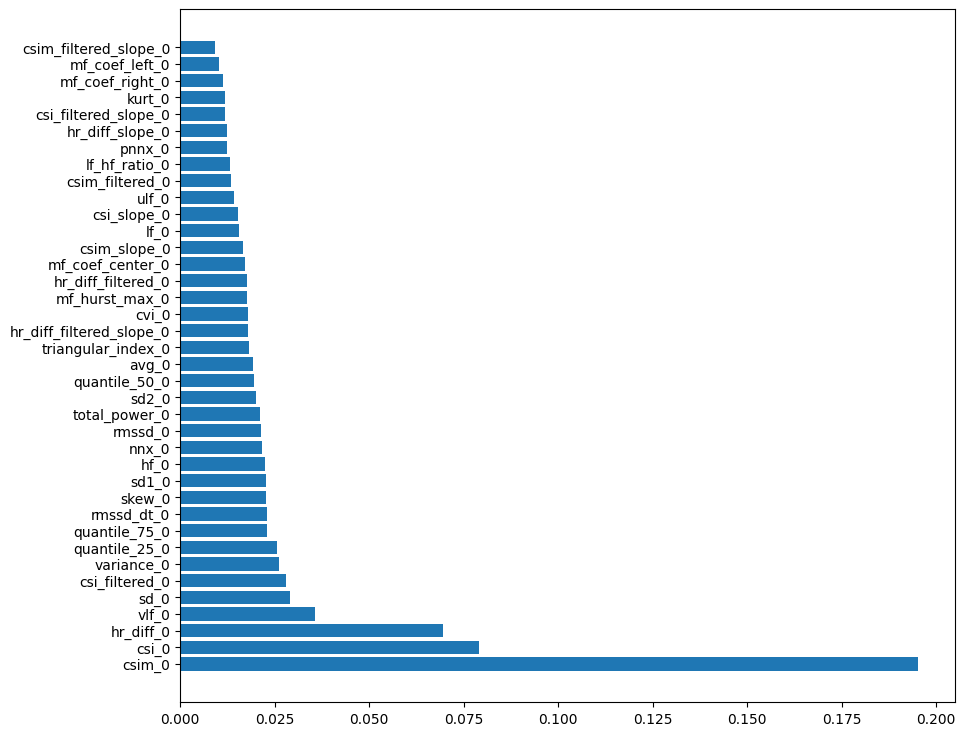

In [13]:
fig, ax = plt.subplots(figsize=(10,9))
ax = plt.barh(df_feature_importance["features"], df_feature_importance["importance"])

In [14]:
def perm_importance(model, X, y):
    perm_importance = permutation_importance(estimator=model, X=X, y=y,scoring="recall", n_repeats=10)
    df_perm_importance = pd.DataFrame(
        {
            "feature": X.columns,
            "perm_importance": perm_importance["importances_mean"]
        }
    ).sort_values(by="perm_importance", ascending=False).reset_index(drop=True)
    return df_perm_importance

In [15]:
df_perm_importance = perm_importance(model, pd.concat([X_val, X_test]), pd.concat([y_val, y_test]))

In [16]:
df_perm_importance

,feature,perm_importance
0,hr_diff_0,0.114141
1,vlf_0,0.073232
2,csi_0,0.072727
3,sd_0,0.072222
4,skew_0,0.067172
5,csim_0,0.044949
6,total_power_0,0.029798
7,hr_diff_filtered_0,0.019192
8,mf_hurst_max_0,0.018687
9,quantile_25_0,0.017677


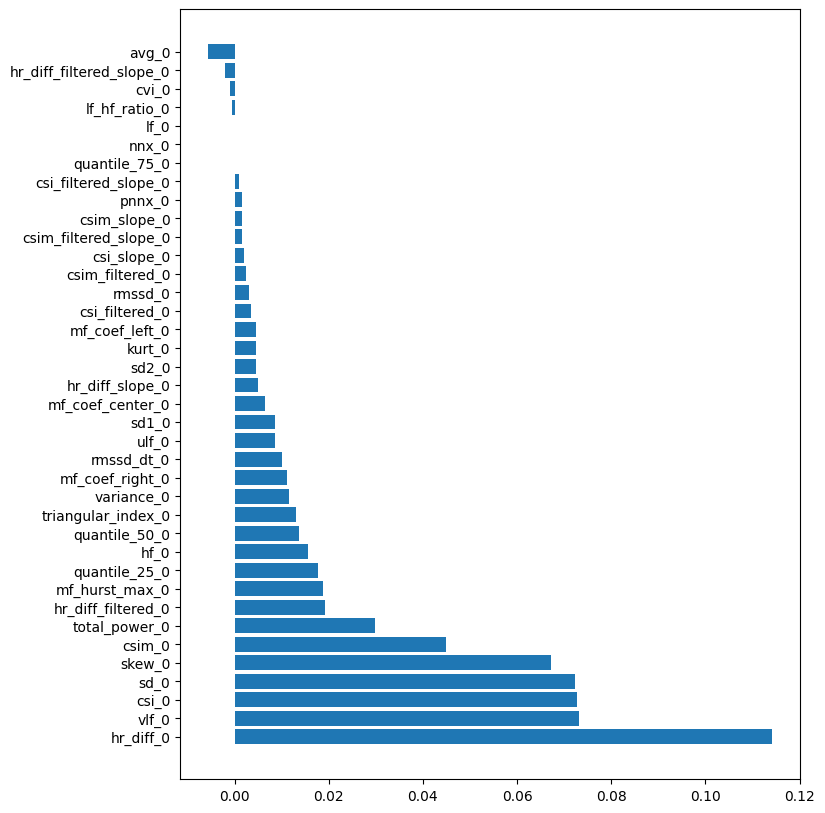

In [17]:
fig, ax = plt.subplots(figsize=(8,10))
ax = plt.barh(df_perm_importance["feature"], df_perm_importance["perm_importance"])

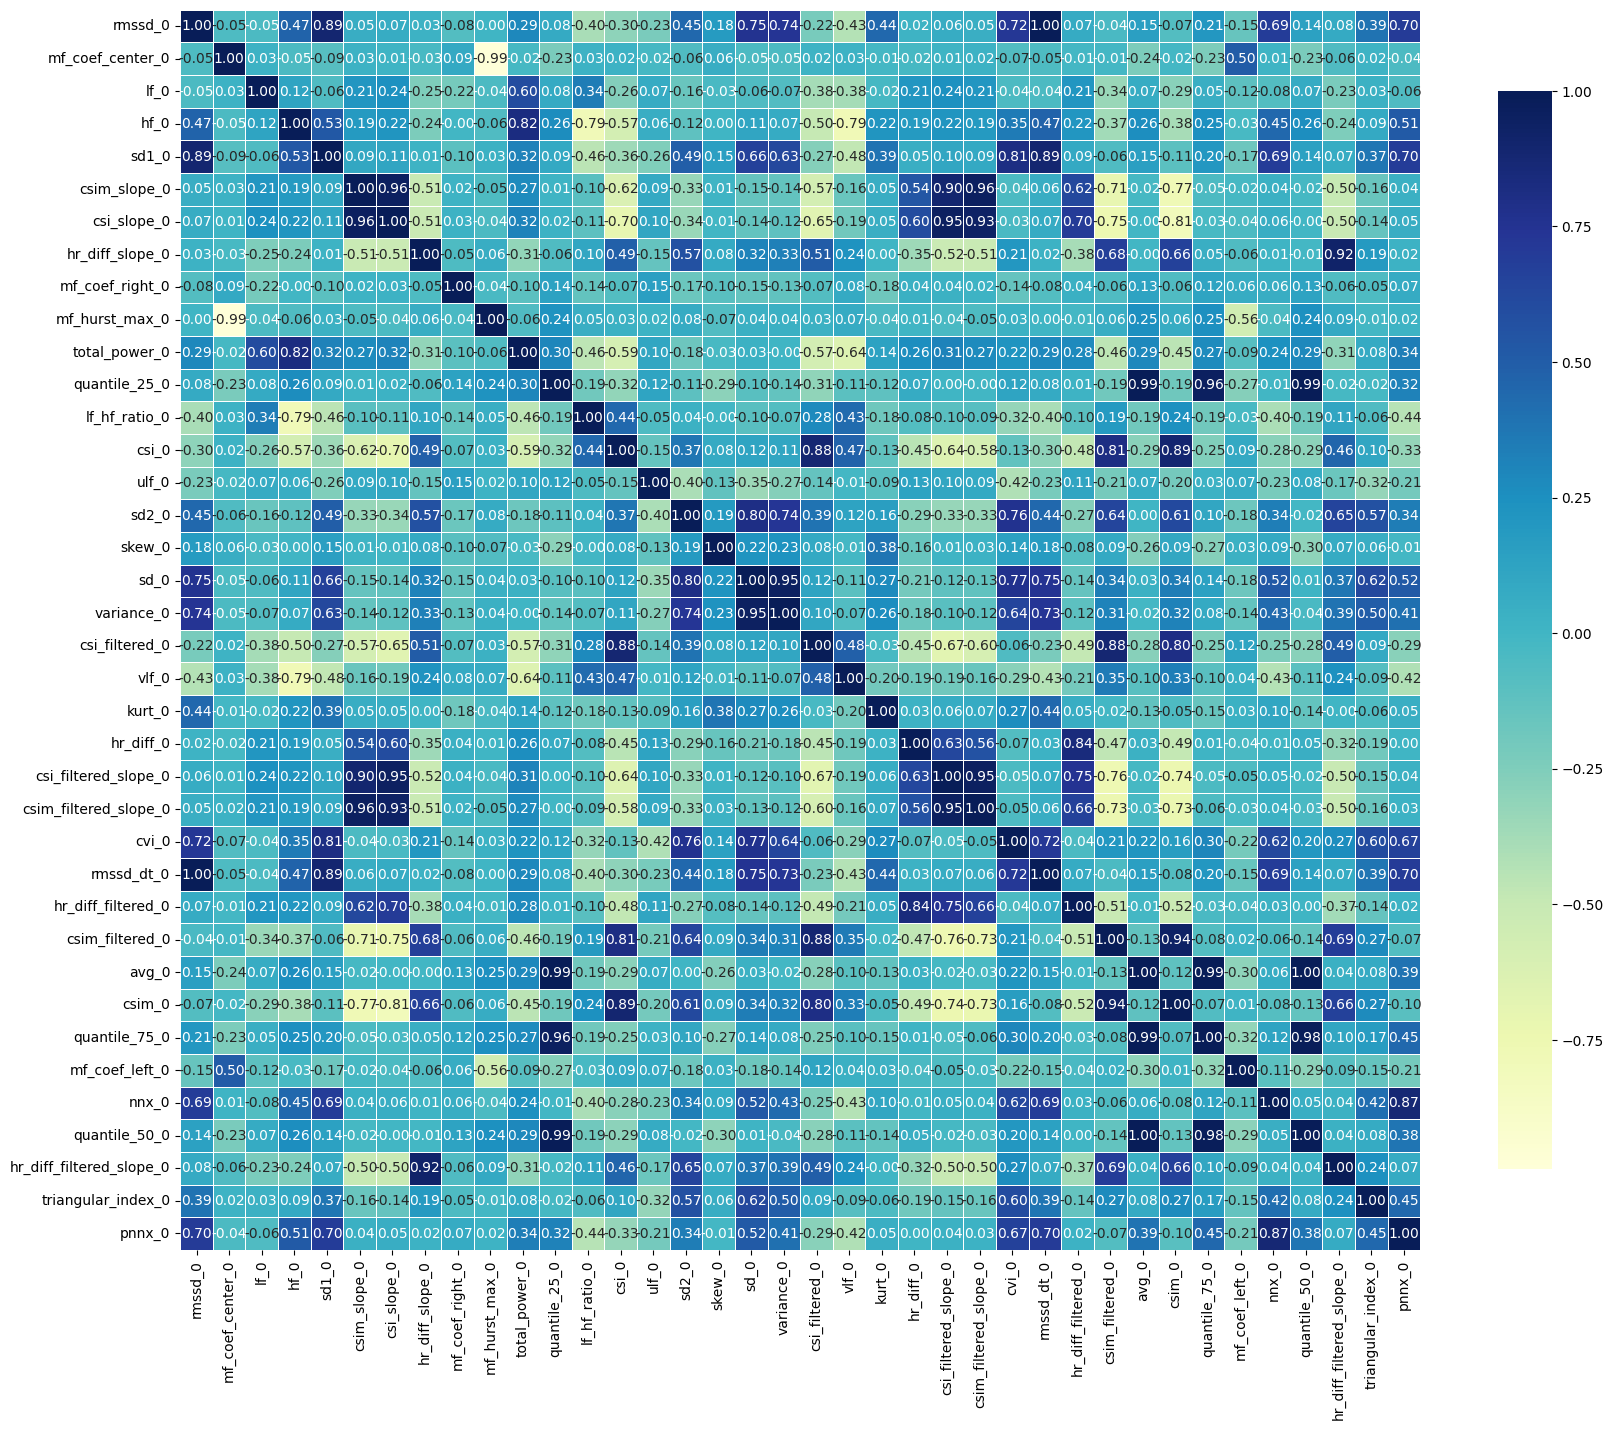

In [18]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(20,20))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();
    
correlation_heatmap(X_train)

In [19]:
correlations = X_train.corr()

In [20]:
correlations

,rmssd_0,mf_coef_center_0,lf_0,hf_0,sd1_0,csim_slope_0,csi_slope_0,hr_diff_slope_0,mf_coef_right_0,mf_hurst_max_0,...,csim_filtered_0,avg_0,csim_0,quantile_75_0,mf_coef_left_0,nnx_0,quantile_50_0,hr_diff_filtered_slope_0,triangular_index_0,pnnx_0
rmssd_0,1.000000,-0.052968,-0.046616,0.466615,0.890541,0.052864,0.067845,0.029024,-0.077249,0.004371,...,-0.035294,0.151530,-0.071487,0.205228,-0.154431,0.694461,0.141324,0.076950,0.388422,0.701456
mf_coef_center_0,-0.052968,1.000000,0.026871,-0.045128,-0.089095,0.027113,0.012807,-0.027782,0.090172,-0.987471,...,-0.009827,-0.235468,-0.015761,-0.234691,0.504326,0.007454,-0.231578,-0.057621,0.016751,-0.043953
lf_0,-0.046616,0.026871,1.000000,0.120361,-0.061737,0.208627,0.244001,-0.245959,-0.217448,-0.041939,...,-0.336399,0.065319,-0.287172,0.052316,-0.117668,-0.076687,0.070459,-0.232073,0.029781,-0.058413
hf_0,0.466615,-0.045128,0.120361,1.000000,0.528124,0.191211,0.222443,-0.239956,-0.002769,-0.058401,...,-0.369872,0.260717,-0.382842,0.251451,-0.031829,0.445300,0.260632,-0.244014,0.091294,0.513601
sd1_0,0.890541,-0.089095,-0.061737,0.528124,1.000000,0.091918,0.110671,0.014371,-0.104326,0.029764,...,-0.062849,0.152398,-0.105369,0.202343,-0.172449,0.691410,0.143293,0.067665,0.374491,0.695216
csim_slope_0,0.052864,0.027113,0.208627,0.191211,0.091918,1.000000,0.959738,-0.507531,0.016221,-0.053238,...,-0.712961,-0.017710,-0.773325,-0.045163,-0.022401,0.042835,-0.020410,-0.495415,-0.156922,0.039374
csi_slope_0,0.067845,0.012807,0.244001,0.222443,0.110671,0.959738,1.000000,-0.514465,0.028317,-0.040806,...,-0.748846,-0.004140,-0.807746,-0.029640,-0.041787,0.056188,-0.003787,-0.498439,-0.142534,0.053147
hr_diff_slope_0,0.029024,-0.027782,-0.245959,-0.239956,0.014371,-0.507531,-0.514465,1.000000,-0.051992,0.059200,...,0.680164,-0.001572,0.660955,0.047166,-0.056605,0.006635,-0.011667,0.921557,0.192119,0.024582
mf_coef_right_0,-0.077249,0.090172,-0.217448,-0.002769,-0.104326,0.016221,0.028317,-0.051992,1.000000,-0.039297,...,-0.059045,0.126815,-0.059635,0.118157,0.060925,0.057438,0.127187,-0.059104,-0.054156,0.073275
mf_hurst_max_0,0.004371,-0.987471,-0.041939,-0.058401,0.029764,-0.053238,-0.040806,0.059200,-0.039297,1.000000,...,0.055022,0.248511,0.061569,0.250720,-0.557306,-0.040807,0.244282,0.090817,-0.010780,0.017671


In [21]:
correlation_dict = {}
for index, row in correlations.iterrows():
    correlated_features = []
    for feature, value in row.items():
        if index != feature and value >= 0.8:
            correlated_features.append(feature)
    correlation_dict[index] = correlated_features
        

What we do now is we calculate the permuatation importance for each feature, where we delete all correlated columns beforehand

In [22]:
 params = {
        'objective': 'binary:logistic',  # Binary classification objective
        'learning_rate': 0.1,  # Learning rate
        'max_depth': 7, # Maximum depth of each tree
        'n_estimators': 300,
        'subsample': 0.8,  # Subsample ratio of the training instances
        'colsample_bytree': 0.8,  # Subsample ratio of features when constructing each tree
        'scale_pos_weight': 0.9,
    }

permutation_importance_dict = {}

for key, value in correlation_dict.items():
    X_train_f = X_train.drop(columns=value)
    X_test_f = X_test.drop(columns=value)
    X_val_f = X_val.drop(columns=value)
    
    # Create the XGBoost classifier
    model = XGBClassifier(**params)

    # Train the XGBoost model
    model.fit(X_train_f, y_train)

    df_perm = perm_importance(model, pd.concat([X_val_f, X_test_f]), pd.concat([y_val,y_test]))

    permutation_importance_dict[key] = df_perm[df_perm.feature == key].perm_importance


In [23]:
values = []
keys = []
for key, value in permutation_importance_dict.items():
    values.append(value.values[0])
    keys.append(key)

In [24]:
permutation_importance_df = pd.DataFrame({
    "feature": keys,
    "importance": values
})

In [25]:
permutation_importance_df = permutation_importance_df.sort_values(by="importance", ascending=False).reset_index(drop=True)

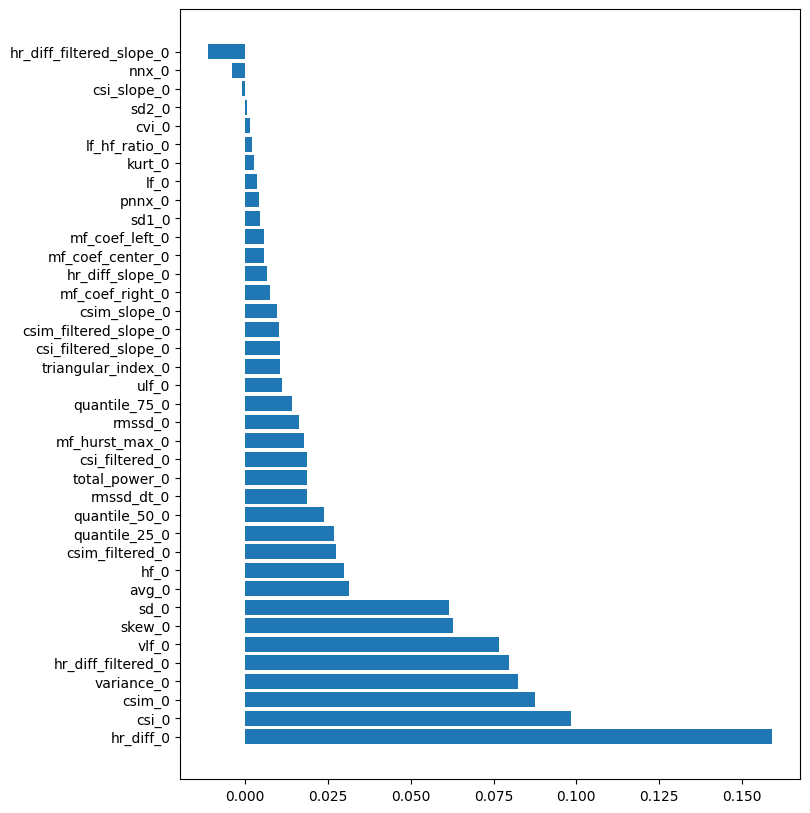

In [26]:
fig, ax = plt.subplots(figsize=(8,10))
ax = plt.barh(permutation_importance_df.feature, permutation_importance_df.importance)

## Shap importance values

In [27]:
import shap
from shap import Explainer

In [28]:
df = load_and_prep_data()
print(df.shape)
df_val, df_test, df_train = train_test_val_split(df)

[creating new connection]
(3320, 2092)


In [29]:
X_train, y_train, X_test, y_test, X_val, y_val = create_splits(df_train, df_test, df_val, features, 0)

In [30]:
model, (accuracy, cm, cr, recall_1, recall_0) = fit_and_eval(X_train, y_train, X_test, y_test)

In [31]:
# Create an explainer object
explainer = shap.Explainer(model)

# Calculate SHAP values
shap_values = explainer(pd.concat([X_test, X_val]))

In [32]:
shap_values

.values =
array([[ 0.12228611,  0.00842205,  0.00221515, ..., -0.3261186 ,
         0.5101835 , -0.17731176],
       [ 0.09080184, -0.11539654,  0.19533707, ..., -0.38898864,
        -0.16812925, -0.0436371 ],
       [ 0.06793079, -0.04645401, -0.06365836, ..., -0.02387023,
        -0.3002264 , -0.07670204],
       ...,
       [ 0.01536762,  0.01740316,  0.14724898, ..., -0.08891589,
        -0.29257688, -0.14295135],
       [ 0.13765702, -0.3815656 , -0.14603002, ..., -0.10537127,
        -0.23231368, -0.10284438],
       [-0.01256602, -0.16828173, -0.21294412, ..., -0.2193872 ,
        -0.20790957, -0.18928583]], dtype=float32)

.base_values =
array([-2.5802414, -2.5802414, -2.5802414, -2.5802414, -2.5802414,
       -2.5802414, -2.5802414, -2.5802414, -2.5802414, -2.5802414,
       -2.5802414, -2.5802414, -2.5802414, -2.5802414, -2.5802414,
       -2.5802414, -2.5802414, -2.5802414, -2.5802414, -2.5802414,
       -2.5802414, -2.5802414, -2.5802414, -2.5802414, -2.5802414,
       -2.5

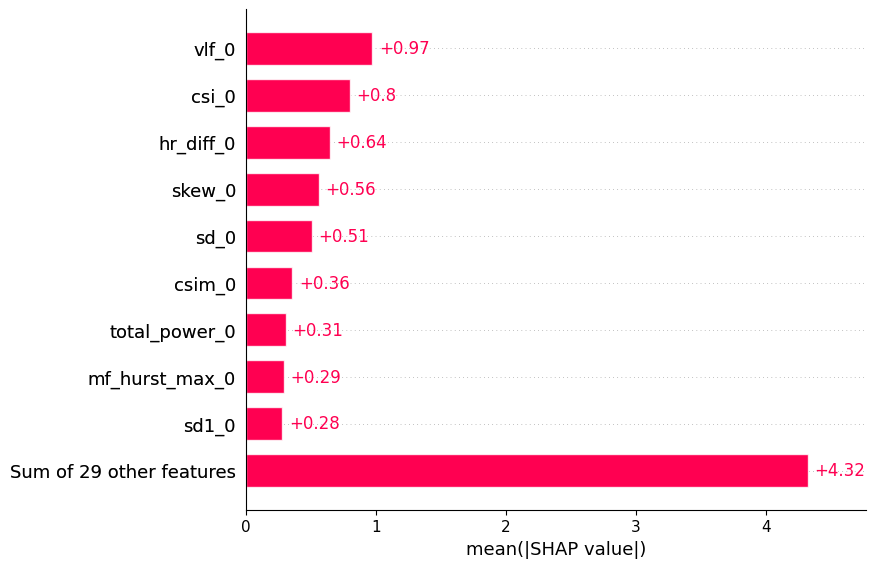

In [33]:
#shap_values.display_data = X_train.columns
shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


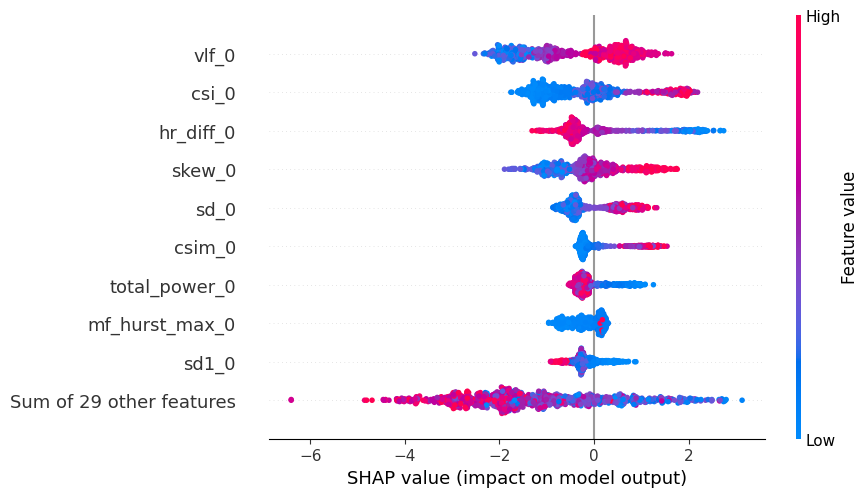

In [34]:
shap.plots.beeswarm(shap_values)

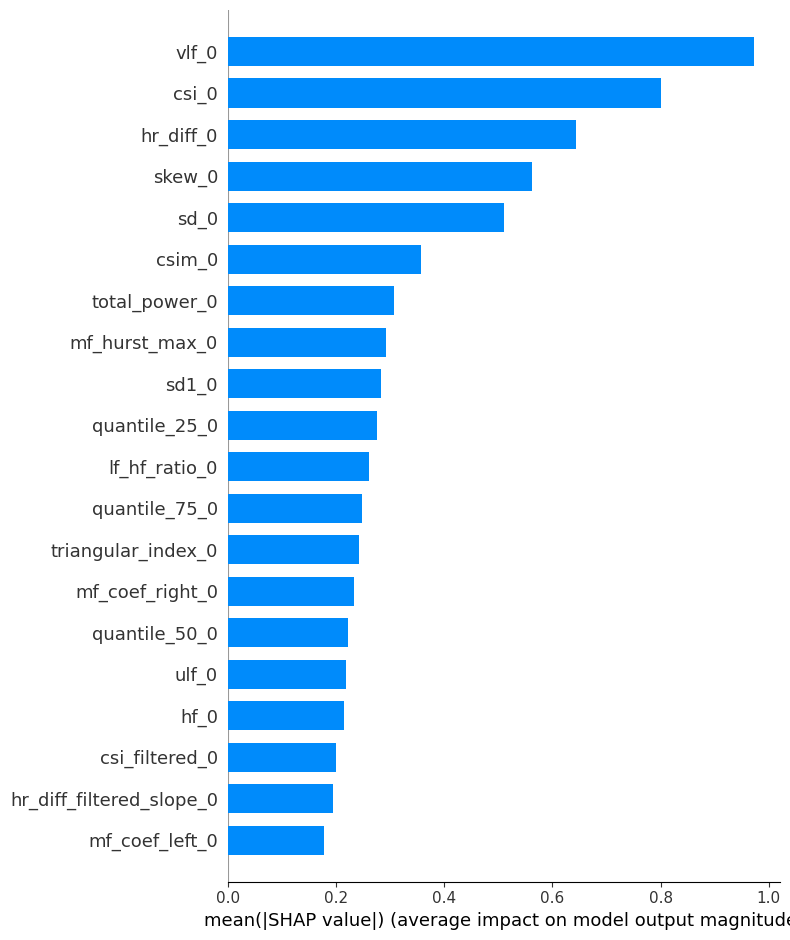

In [35]:

shap.summary_plot(shap_values, pd.concat([X_test, X_train]), plot_type="bar")

### Partial Dependency plots

In [36]:
X_train, y_train, X_test, y_test, X_val, y_val = create_splits(df_train, df_test, df_val, features, 0)

In [37]:
model, (accuracy, cm, cr, recall_1, recall_0) = fit_and_eval(X_train, y_train, X_test, y_test)

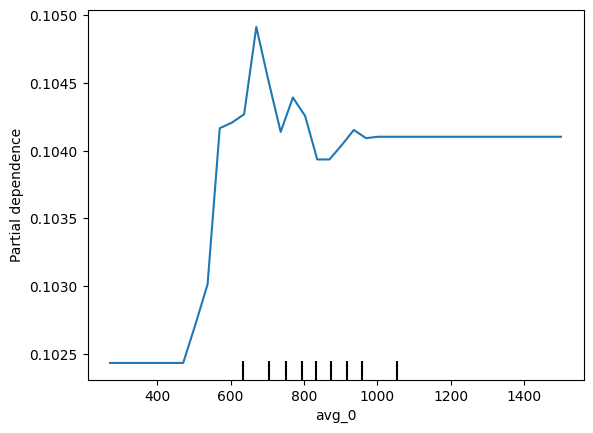

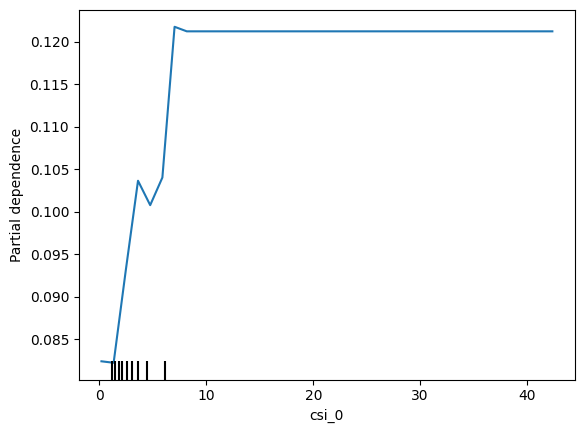

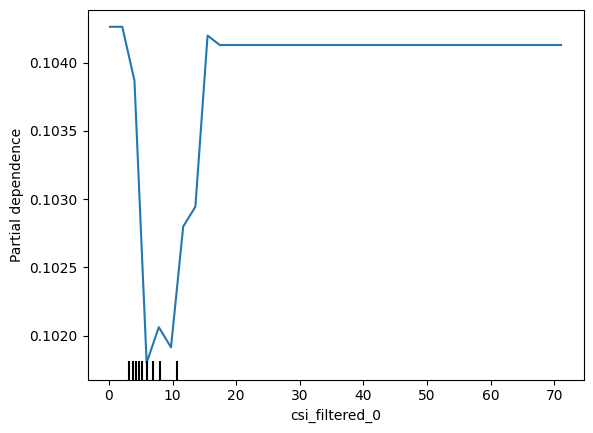

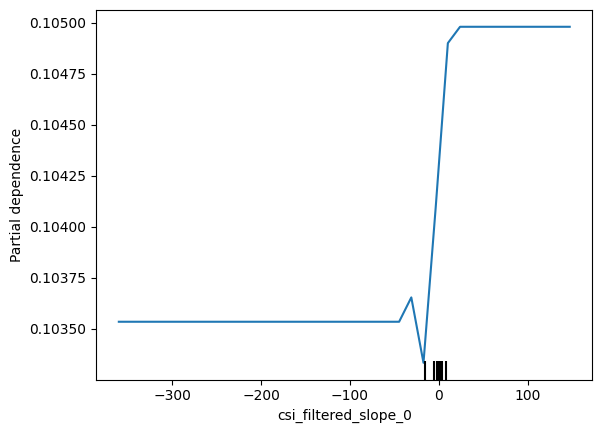

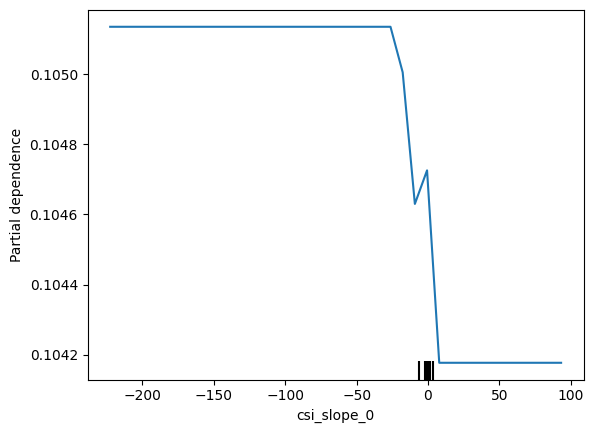

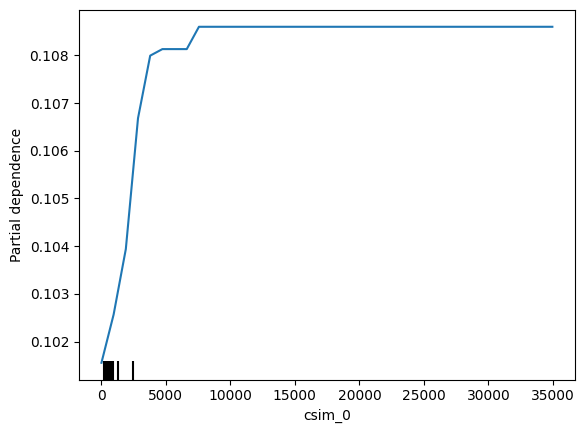

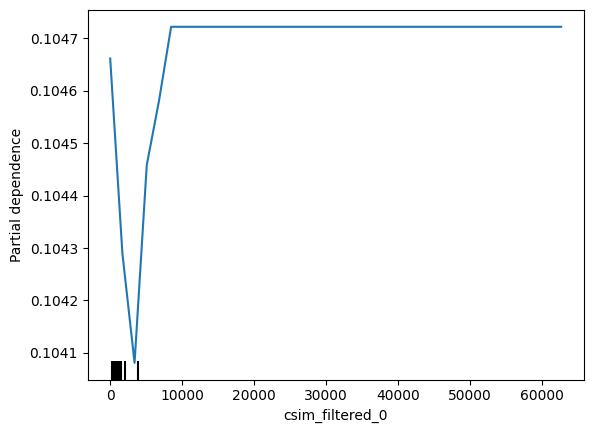

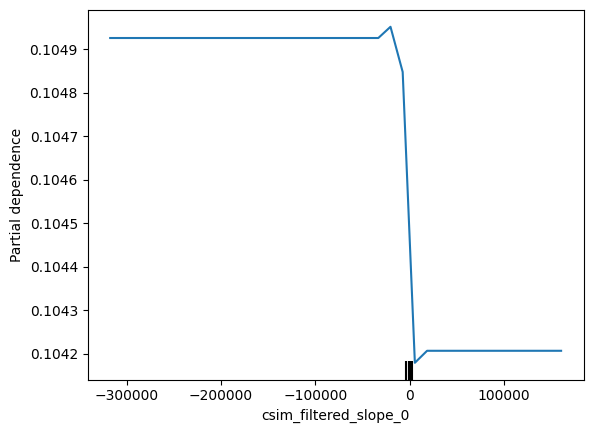

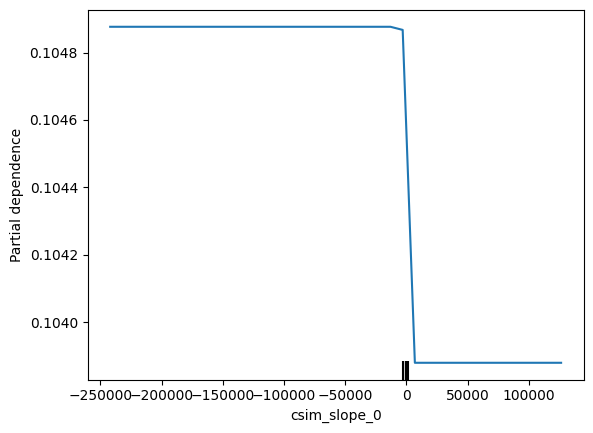

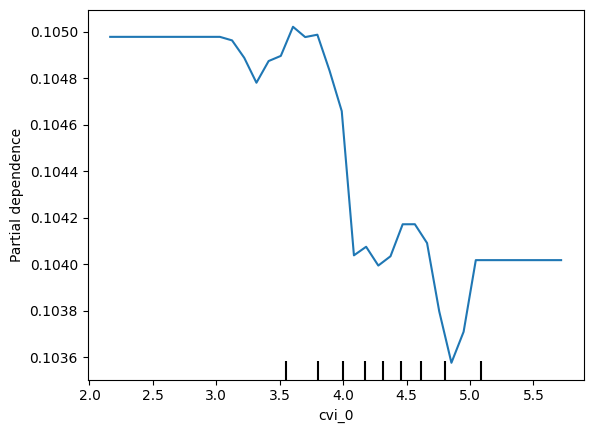

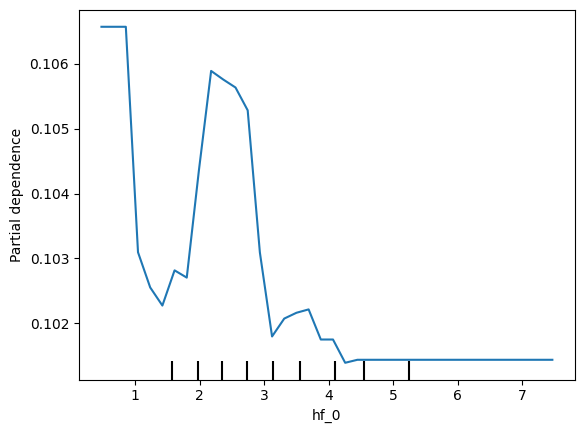

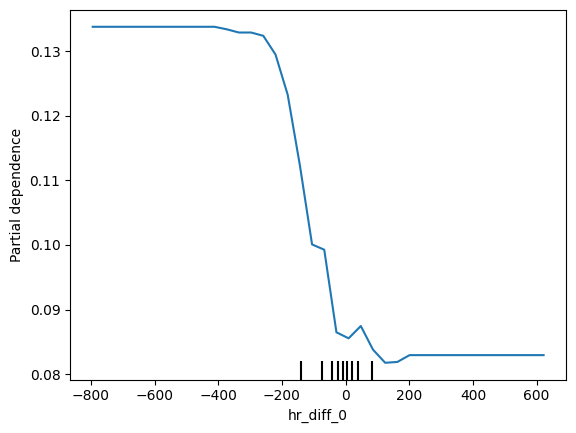

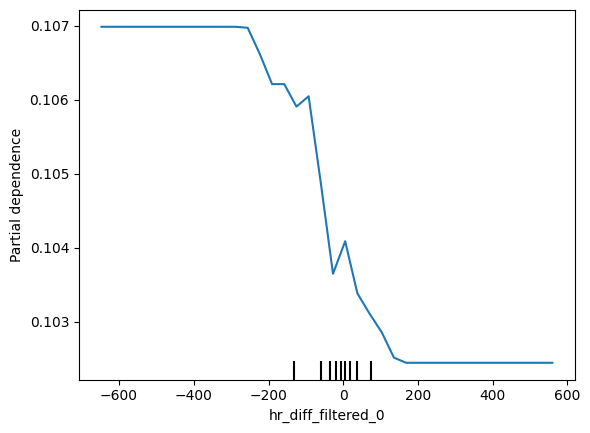

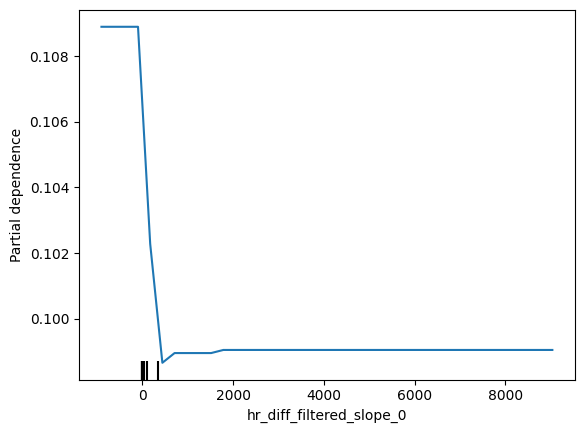

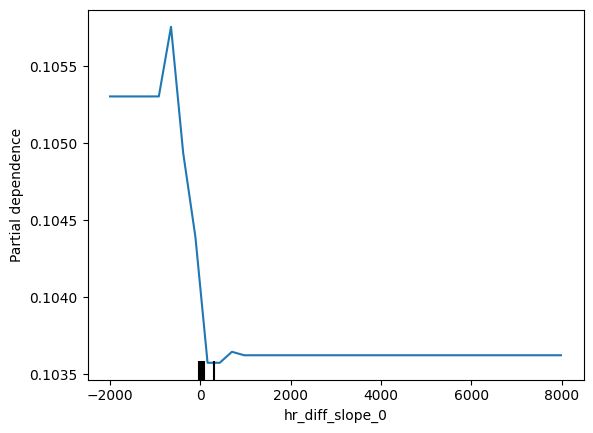

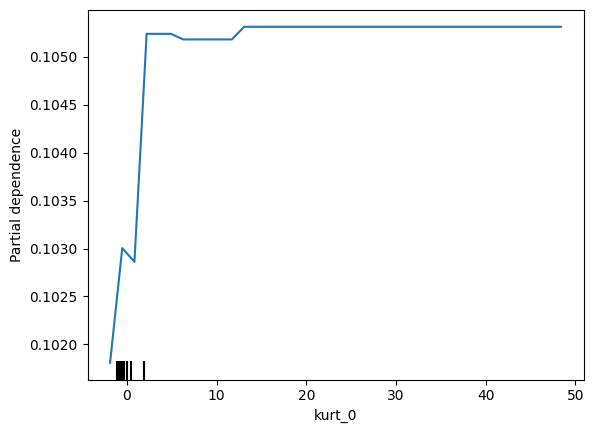

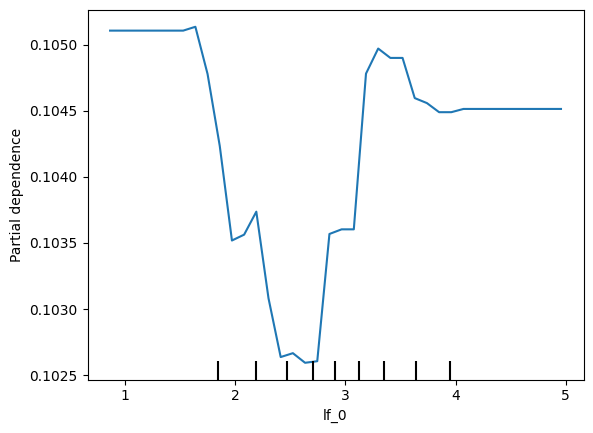

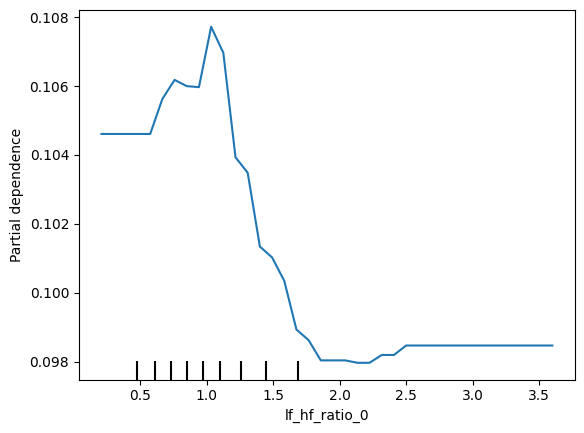

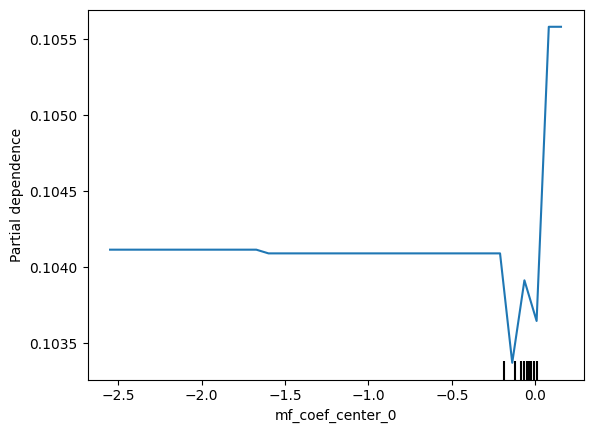

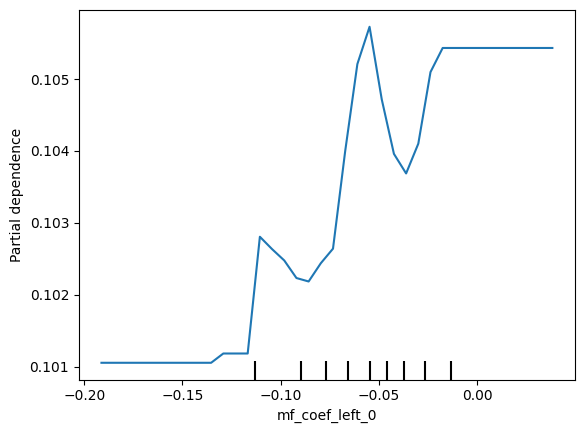

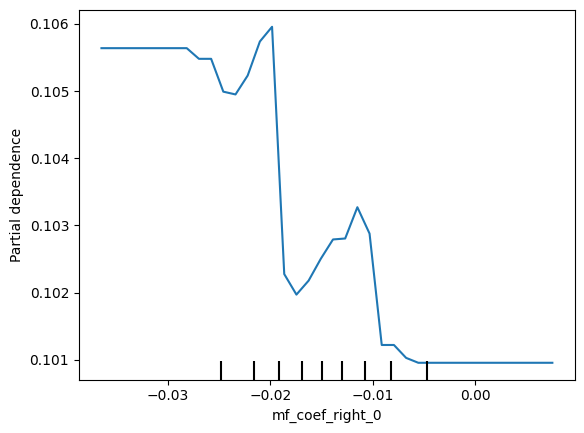

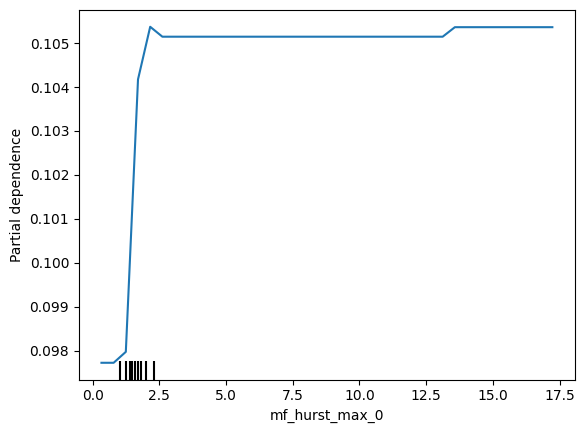

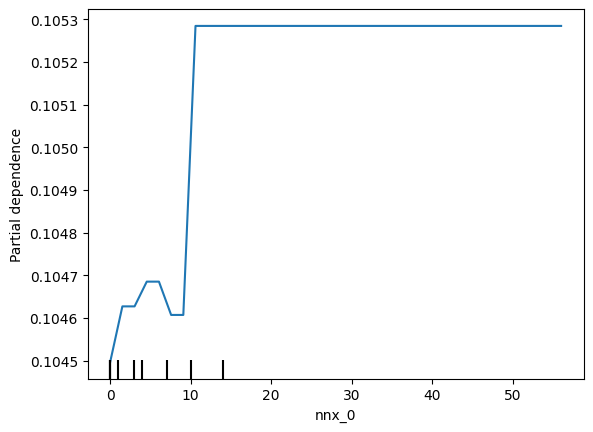

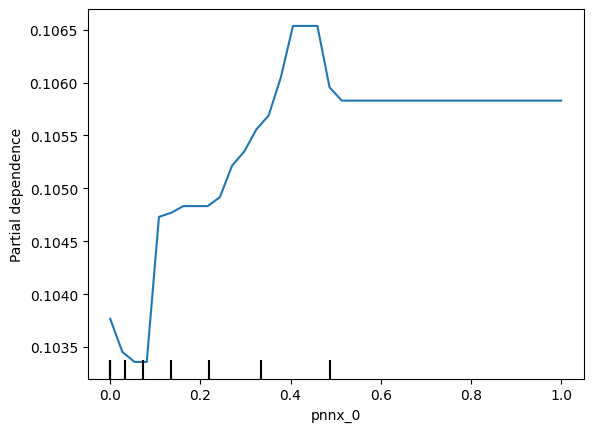

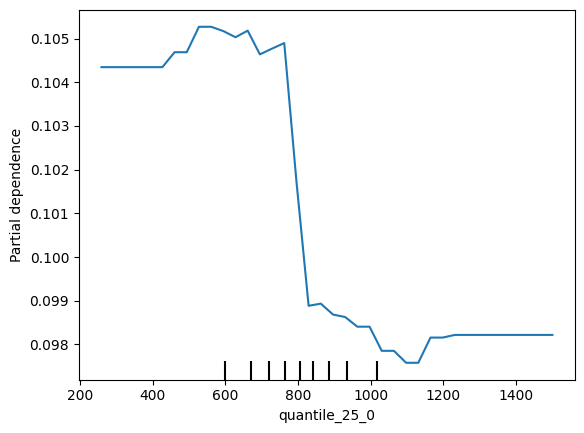

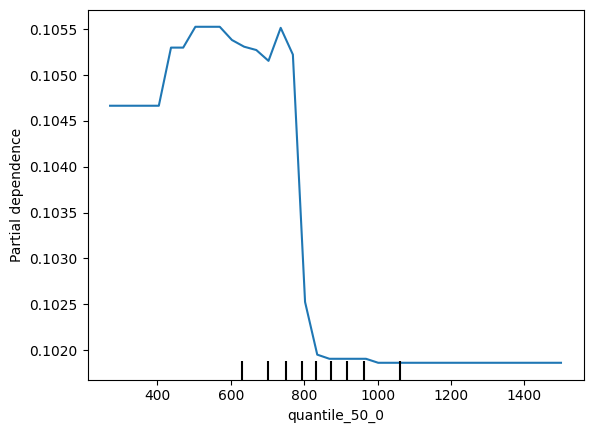

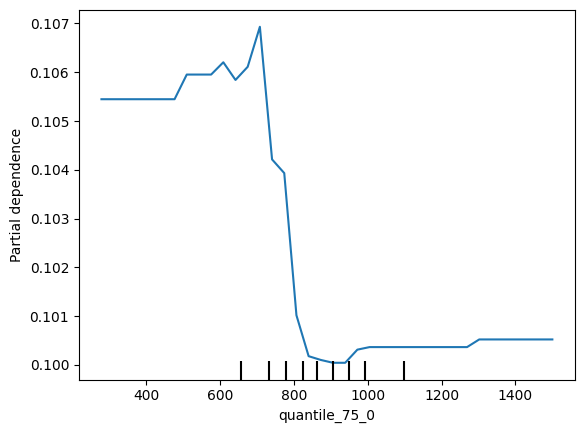

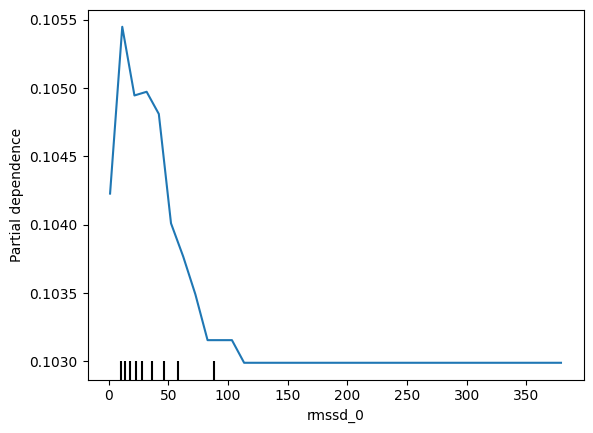

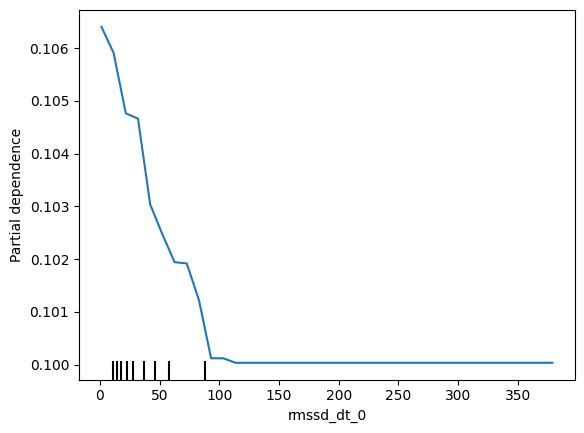

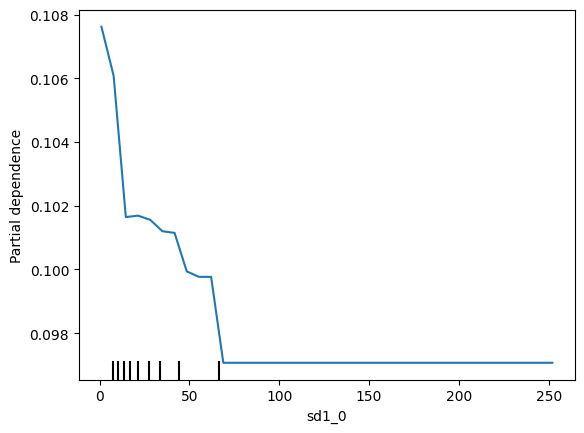

In [38]:
# partial dependency
for feature in sorted(list(X_train.columns))[:30]:
    PartialDependenceDisplay.from_estimator(model, X_train, [feature],grid_resolution=38, percentiles=(0, 1))
    plt.show()

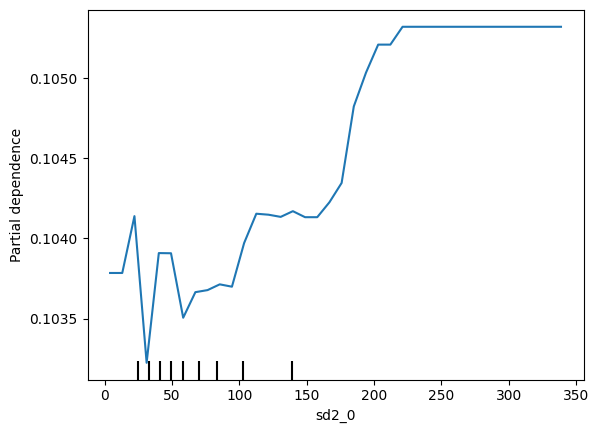

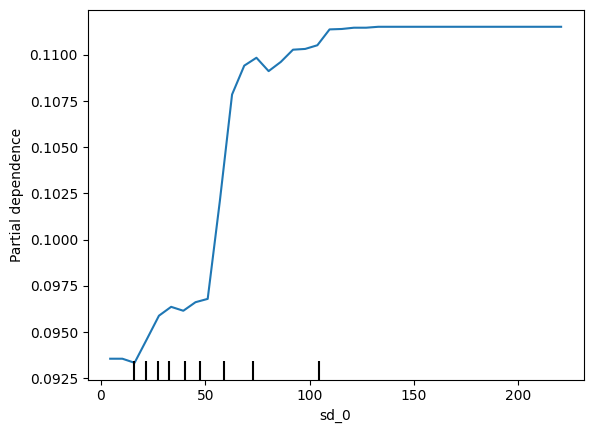

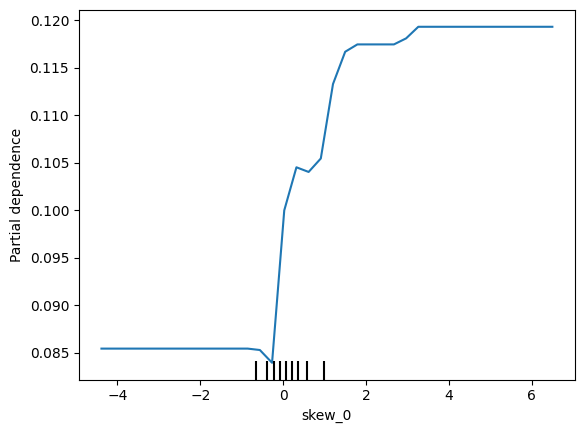

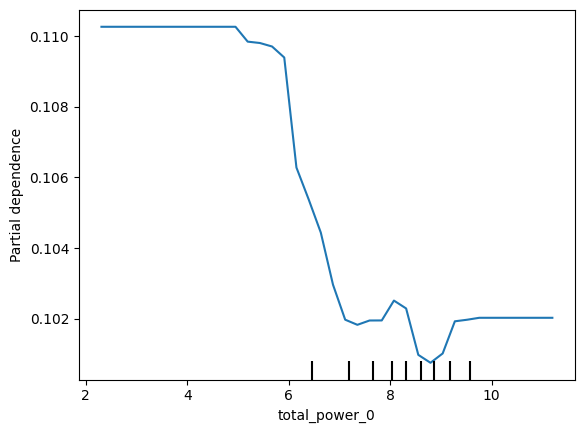

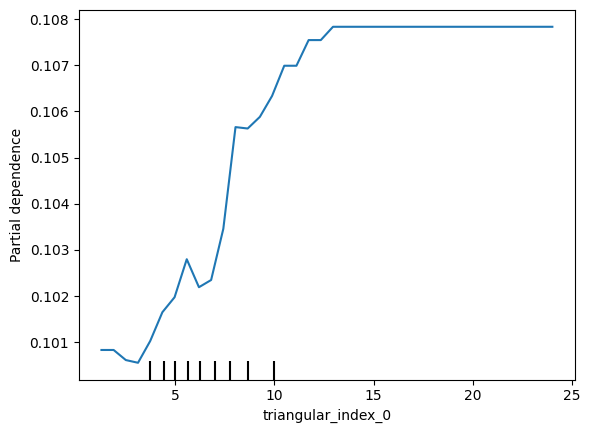

ValueError: percentiles are too close to each other, unable to build the grid. Please choose percentiles that are further apart.

In [39]:
# partial dependency
for feature in sorted(list(X_train.columns))[30:39]:
    PartialDependenceDisplay.from_estimator(model, X_train, [feature],grid_resolution=38, percentiles=(0, 1))
    plt.show()